## Лабораторная работа 1: Алгоритмы разложения матриц. PCA.
_Команда 2_ <br>
_Винниченко, Карцева, Масалимова, Пищулов_
### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [62]:
def QR(a):
    b = np.array([np.transpose(a)[0]])
    for i in range(1, len(np.transpose(a))):
        proj_a = 0
        for j in range(len(b)):
            proj_a -=  (np.dot(np.transpose(a)[i], b[j])/np.dot(b[j], b[j])) * b[j]
        b_el = np.transpose(a)[i] + proj_a
        b = np.vstack([b, b_el])
    for i in range(len(b)):
        b[i] = b[i] / np.sqrt(np.dot(b[i],b[i]))
    Q = -b
    R = np.dot(Q, a)
    return Q.T, R #Q - собственные вектора, R - собственные значения

In [63]:
def cal_nullspace(A):
    A = A.copy()
    epsilon = 1e-9
    A_shape = A.shape
    
    for i in range(A_shape[0] - 1):
        if np.abs(A[i, i]) <= epsilon:
            
            for j in range(i+1, A_shape[0]):
                if np.abs(A[j,i]) > epsilon:  
                   
                    A[j,:], A[i,:] = A[i],A[j,:]

        if np.abs(A[i,i]) <= epsilon:
       
            continue

        for j in range(i+1, A_shape[0]):

            A[j,:] = A[j,:] -  1.0 * A[j,i]/A[i,i] * A[i,:];

    for i in range(A_shape[0]):
        if np.abs(A[i,i]) > epsilon:

            A[i,:] = A[i,:] * (1.0/A[i,i]) 
    

    free_eles = np.zeros(A_shape[0], dtype='int') 
    cn = 0
    eigv = np.zeros(A_shape[0])
    for i in range(A_shape[0]):
        if np.abs(A[i,i]) < epsilon:
            free_eles[cn] = i
            cn += 1

    if cn == 0:
        return None

    ns = np.zeros((A_shape[0], cn))

    for i in range(cn):
        ns[free_eles[i], i] = 1
        for j in range(A_shape[0] - 1, -1, -1):
            if np.abs(A[j,j]) > epsilon:
                ns[j, i] = 0 - np.dot(A[j, j+1:], ns[j+1:, i])

    if cn >= 2:   
        q,r = QR(ns)
        ns = q
    else:
        sq = np.sqrt(np.dot(ns[:,0], ns[:,0]))
        ns /= sq
        
    return ns 

In [64]:
def eigen_qr_simple(A):
    Ak = np.copy(A)
    e = 1e-9
    t = 0
    while True:
        Q, R = QR(Ak)
        Ak = R @ Q
        t = 0
        for i in range(1, A.shape[1]):
            for j in range(0,i):
                t += np.abs(Ak[i,j])
        if t <= e:
            break
    return np.diag(Ak)

In [65]:
def eig(A):
    eig_vals = np.sort(eigen_qr_simple(A))[::-1] 
    A_shape = A.shape
    eig_vectors=np.zeros((A.shape[0], A.shape[0]))
    preval = None
    curid=0
    for eigval in eig_vals:
        if preval == eigval:
            continue
        A_eig = A - np.eye(A_shape[0]) * eigval
        cur_vectors = cal_nullspace(A_eig)
        preval = eigval
    
        for i in range(cur_vectors.shape[1]):
            eig_vectors[:, curid] = cur_vectors[:, i]  
            curid += 1

    return (eig_vals,eig_vectors)

In [66]:
np.linalg.eig(quad)

(array([-0.98293008+0.j        ,  0.24965626+0.j        ,
         0.06456677+0.13273506j,  0.06456677-0.13273506j,
        -0.18607132+0.j        ]),
 array([[ 0.36232315+0.j        , -0.91067857+0.j        ,
          0.10223342-0.22306698j,  0.10223342+0.22306698j,
         -0.51873913+0.j        ],
        [ 0.55040413+0.j        , -0.00445332+0.j        ,
         -0.29112652-0.17555076j, -0.29112652+0.17555076j,
         -0.70319285+0.j        ],
        [ 0.60702945+0.j        , -0.09656331+0.j        ,
         -0.39773219+0.40191578j, -0.39773219-0.40191578j,
         -0.04307497+0.j        ],
        [ 0.30901346+0.j        , -0.38647573+0.j        ,
          0.58434878+0.j        ,  0.58434878-0.j        ,
         -0.28833869+0.j        ],
        [ 0.31906607+0.j        , -0.10934691+0.j        ,
          0.35823222-0.18626788j,  0.35823222+0.18626788j,
          0.38914635+0.j        ]]))

In [67]:
def svd(A, retSimple=False):
    epsilon = 1e-4
    A_shape = A.shape

    e,v = eig(A.T @ A)
    e_sqrt = np.sqrt(np.take(e, np.where(e > epsilon)[0]))
    r = len(e_sqrt)

    U = np.zeros((A_shape[0], A_shape[0]))  #m*m
    S = np.zeros(A_shape)                   #m*n
    V = np.zeros((A_shape[1], A_shape[1]))  #n*n

    for i in range(r):
        ui = np.dot(A, v[:,i])
        ui = ui / np.sqrt(np.dot(ui, ui))
        U[:,i] = ui

        S[i,i] = e_sqrt[i]

    if retSimple:
        U = U[:, :r]
        S = S[:r,:r]
        V = v[:, :r].T
    else:
        if r < A_shape[0]:
            ns = cal_nullspace(U.T) 
            U[:,r:] = ns
        V = v.T

    return (U,S,V)

##### Представление набора данных

Source: World Bank Government Indicators  (Kaufmann et al. 2016)

e_wbgi_vae -- voice and accountability (показатель, измеряющий различные аспекты
политического процесса, гражданских свобод и политических прав)

e_wbgi_cce -- control of corruption (показатель восприятия коррупции, традиционно определяемой
как осуществление публичной власти ради частной выгоды)

e_wbgi_gee -- government effectiveness (показатель качества
предоставления государственных услуг, качество бюрократии, компетентность государственных служащих,
независимость государственной службы от политического давления и доверие к правительству

e_wbgi_rle -- rule of law (показатель успеха общества в развитии среды, в
которой справедливые и предсказуемые правила составляют основу экономических и социальных взаимодействий и
в которой права собственности защищены)

e_wbgi_rqe -- regulatory quality (показатель распространенности недружественной к рынку политики
такие как контроль над ценами или неадекватный банковский надзор, а также восприятие бремени
вызванное чрезмерным регулированием в таких областях, как внешняя торговля и развитие бизнеса)

Time period: 1996-2021 (exluding 1997, 1999, 2001)

Sample: 15 post-Soviet countries

In [68]:
#import data
dataframe1 = pd.read_excel("data_lab1.xlsx")
#print(dataframe1)
features = ['e_wbgi_vae', 'e_wbgi_cce', 'e_wbgi_gee', 'e_wbgi_rle', 'e_wbgi_rqe' ]
df1 = dataframe1.loc[:, features].values

#mean centering
mean_values = np.mean(df1, axis = 0)
centred_data = df1 - mean_values
print(centred_data)

[[ 0.37129275 -0.48631014 -0.13632754 -0.16886377 -0.2760029 ]
 [ 0.18529275 -0.38731014 -0.34732754 -0.24686377 -0.3380029 ]
 [ 0.24529275 -0.37631014 -0.35732754 -0.26186377 -0.5660029 ]
 ...
 [ 1.58729275  1.26068986  1.35267246  1.41713623  1.5349971 ]
 [ 1.59929275  1.37168986  1.36667246  1.35213623  1.5029971 ]
 [ 1.63229275  1.41768986  1.37267246  1.53813623  1.6279971 ]]


##### Применение метода сингулярного разложения на данных

In [69]:
U, S, V = svd(centred_data)
U @ S @ V 

array([[ 0.37129275, -0.48631014, -0.13632754, -0.16886377, -0.2760029 ],
       [ 0.18529275, -0.38731014, -0.34732754, -0.24686377, -0.3380029 ],
       [ 0.24529275, -0.37631014, -0.35732754, -0.26186377, -0.5660029 ],
       ...,
       [ 1.58729275,  1.26068986,  1.35267246,  1.41713623,  1.5349971 ],
       [ 1.59929275,  1.37168986,  1.36667246,  1.35213623,  1.5029971 ],
       [ 1.63229275,  1.41768986,  1.37267246,  1.53813623,  1.6279971 ]])

In [70]:
from collections import defaultdict


def get_pca(x):
    centered = x - x.mean(axis=0)
    n, m = centered.shape
    y = centered/np.sqrt(n-1)
    _, sigma, vh = svd(y)
    # print(f'sigma: {sigma}')
    # c = y.T@y
    pr_components = vh.T
    return pr_components

pcs = get_pca(X)
t = X[0]  # first object
sum_distances_by_pc = defaultdict(int)
for pc_num, pc in enumerate(pcs.T):
    for obj in X:
        projection = pc@obj
        sum_distances_by_pc[pc_num] += projection**2

vars = pd.Series(sum_distances_by_pc, index=sorted(list(sum_distances_by_pc.keys())))
vars /= sum(vars)
vars

0    0.913561
1    0.045756
2    0.024779
3    0.009996
4    0.005907
dtype: float64

In [71]:
selected_pcs = pcs[:, :2]
# selected_pcs
transformed = X@selected_pcs
transformed.shape

(345, 2)

[0.91356135 0.04575646]


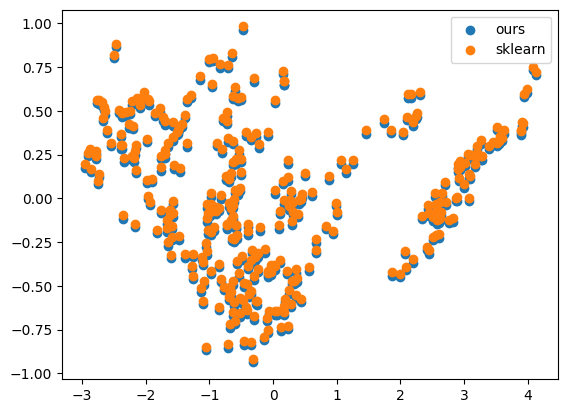

In [72]:
sk_pca = PCA(n_components=2)

sk_pca.fit(X)
print(sk_pca.explained_variance_ratio_)

sk_transformed = sk_pca.transform(X)
plt.scatter(x=transformed[:, 0], y=transformed[:, 1])
plt.scatter(x=sk_transformed[:, 0], y=sk_transformed[:, 1]+0.02)
plt.legend(['ours', 'sklearn'])

##### Преимущества и недостатки применения сингулярного и спектрального разложения к задачам PCA

In [73]:
V.T

array([[ 0.51995133, -0.6869939 ,  0.43011235,  0.18549511, -0.19566533],
       [ 0.37667795,  0.5547068 ,  0.52207325, -0.467948  , -0.24264848],
       [ 0.37364593,  0.38051867, -0.32565004,  0.62861473, -0.4630225 ],
       [ 0.51521436, -0.1684128 , -0.65441618, -0.52670928,  0.02254097],
       [ 0.42744265,  0.21721515,  0.09019093,  0.27209758,  0.8294208 ]])

In [74]:
explained_variances = (S ** 2) / (len(centred_data) - 1)
explained_variances

array([[3.24232359, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.16239442, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0879438 , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

##### Определение числа компонент, визуализация данных, анализ полученных компонент

In [75]:
cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_ratio = cumulative_explained_variance / np.sum(explained_variances)

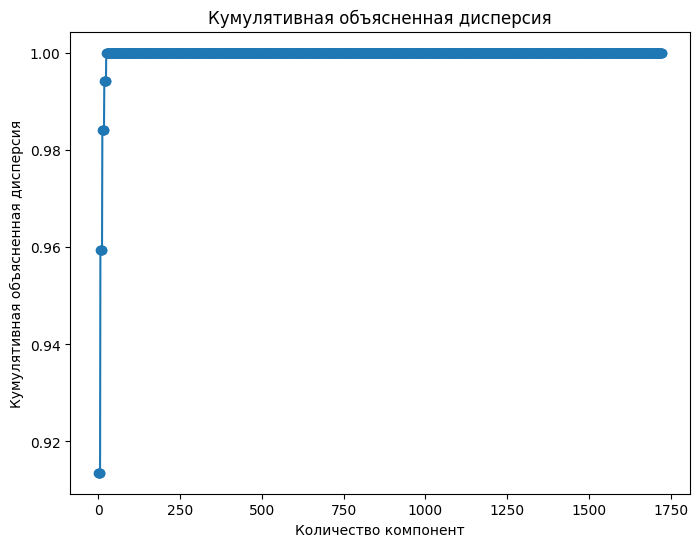

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Кумулятивная объясненная дисперсия')
plt.show()


In [77]:
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1

# Шаг 3: Визуализация данных в новом пространстве компонент
PC_matrix_selected = PC_matrix[:, :num_components] 
transformed_data = np.dot(X, PC_matrix_selected)

NameError: name 'PC_matrix' is not defined

##### Дополнительное задание

### 2. Kernel PCA

##### Представление набора данных

##### Реализация методов вычисления матрицы для различных ядер  и её последующего спектрального разложения

##### Сравнительный анализ применения PCA и Kernel PCA